In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [18]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 128
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



488396 2441 763 610


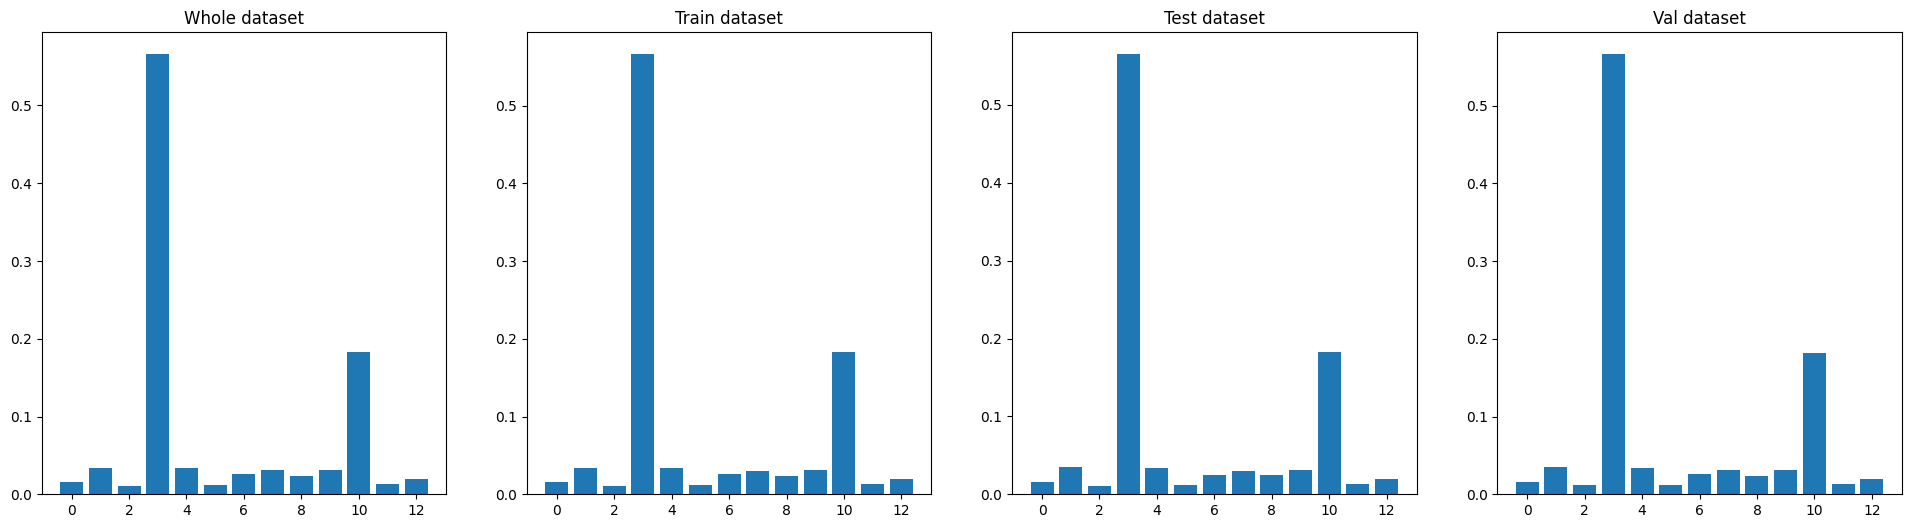

In [19]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

In [20]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([128, 3, 68, 68]) torch.Size([128])


# Autoencoder

In [21]:
from models import CELL_CNN_AutoEncoder

model = CELL_CNN_AutoEncoder(latent_dim=256)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# loss_fn = nn.MSELoss(reduction='sum')

def loss_fn(x, y):
    return F.mse_loss(x, y, reduction='sum') / x.size(0)
# loss_fn = nn.MSELoss()


CELL_CNN_AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=

In [22]:
# test forward pass
x, y = next(iter(train_loader))
print("x.shape:", x.shape)

if cuda:
    x = x.cuda()

output = model(x)

print("output.shape:", output.shape)

assert output.shape == x.shape

x.shape: torch.Size([128, 3, 68, 68])
output.shape: torch.Size([128, 3, 68, 68])


In [23]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_latent{model.latent_dim}_mean_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


CELL_CNN_AutoEncoder_latent256_mean_


## Training

In [24]:
val = True

num_epochs = 50
train_loss = []
val_loss = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    if val:
        model.eval()
        batch_loss = []

        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x = x.cuda()
                output = model(x)
                loss = loss_fn(output, x)
                batch_loss.append(loss.item())
            
            val_loss.append(np.mean(batch_loss))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")




Epoch 1/50, Train Loss: 223.8931, Val Loss: 57.6512
Epoch 2/50, Train Loss: 47.9555, Val Loss: 36.9485
Epoch 3/50, Train Loss: 42.1757, Val Loss: 34.3390
Epoch 4/50, Train Loss: 37.0310, Val Loss: 32.4454
Epoch 5/50, Train Loss: 33.8323, Val Loss: 28.9223
Epoch 6/50, Train Loss: 34.8400, Val Loss: 41.7957
Epoch 7/50, Train Loss: 33.1074, Val Loss: 27.5514
Epoch 8/50, Train Loss: 30.5219, Val Loss: 26.5510
Epoch 9/50, Train Loss: 29.1831, Val Loss: 25.9033
Epoch 10/50, Train Loss: 28.3664, Val Loss: 25.3356
Epoch 11/50, Train Loss: 27.7157, Val Loss: 24.3178
Epoch 12/50, Train Loss: 27.0556, Val Loss: 23.8953
Epoch 13/50, Train Loss: 26.6282, Val Loss: 23.0652
Epoch 14/50, Train Loss: 26.3295, Val Loss: 22.8401
Epoch 15/50, Train Loss: 25.5621, Val Loss: 22.4078
Epoch 16/50, Train Loss: 25.1442, Val Loss: 22.3187
Epoch 17/50, Train Loss: 24.8566, Val Loss: 22.3184
Epoch 18/50, Train Loss: 25.0459, Val Loss: 21.4127
Epoch 19/50, Train Loss: 24.3025, Val Loss: 21.1492
Epoch 20/50, Train L

# Evaluate model on test set

In [25]:
test_loss = []
model.eval()

with torch.no_grad():
    for x, y in test_loader:
        if cuda:
            x = x.cuda()
        output = model(x)
        loss = loss_fn(output, x)
        test_loss.append(loss.item())

print(f"Test Loss: {np.mean(test_loss):.4f}")





Test Loss: 18.0424


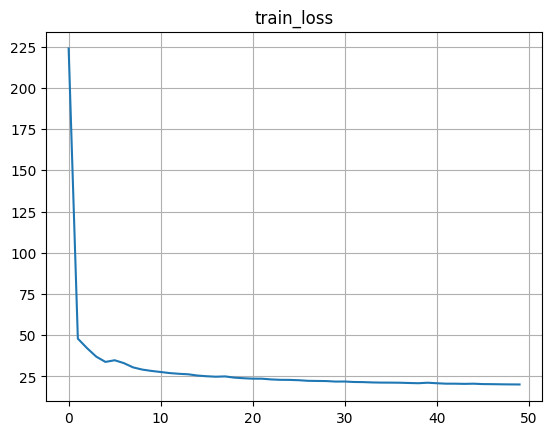

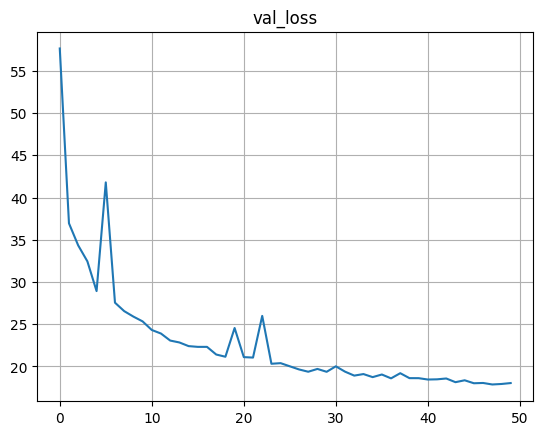

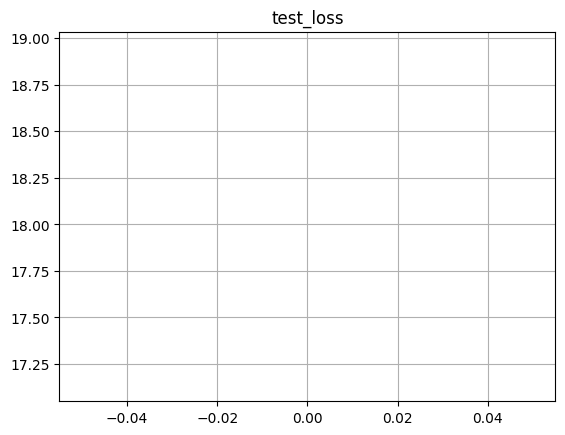

In [26]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["val_loss"] = val_loss
loss_data["test_loss"] = np.mean(test_loss)

loss_plots(loss_data, invidual_plots=True, title="")

df = pd.DataFrame(loss_data)
try:
    old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv", index=False)
